Install libraries

In [ ]:
!pip install -r requirements.txt

# The problem

Imagine that we have a delivery-marketplace. We have a set of couriers and clients which make orders (from arbitary point A to arbitary point B in our city). We want to understand how to assign couriers on orders optimaly.

Let's formilize the problem.

The heart of our algorithm is a dispatch. Every time interval (let's say every minute) it recieves the information about free couriers, free (unassigned) orders and current orders (which are in progress). I call this triplet of sets a `gable-triple`. Dispatch needs to say how to match free couriers to free orders.

### Gamble-triple

`0s` is the start point of order 0, `0f` is finish point. `0` without letter is a position of courier 0

Orders:
Order; id: 0; from: (7.599691536443254, 5.818680092330323); to: (5.298652555508607, 4.078729129466528)
Order; id: 1; from: (1.5776891866584264, 5.34243659727336); to: (7.434943108945246, 1.2089768320173122)
Couriers:
Courier;  id: 0; pos: (6.911138974835266, 8.353979232875869)
Courier;  id: 1; pos: (6.843953134082711, 8.746170716195596)
Courier;  id: 2; pos: (1.8151131737020199, 1.94630618459817)


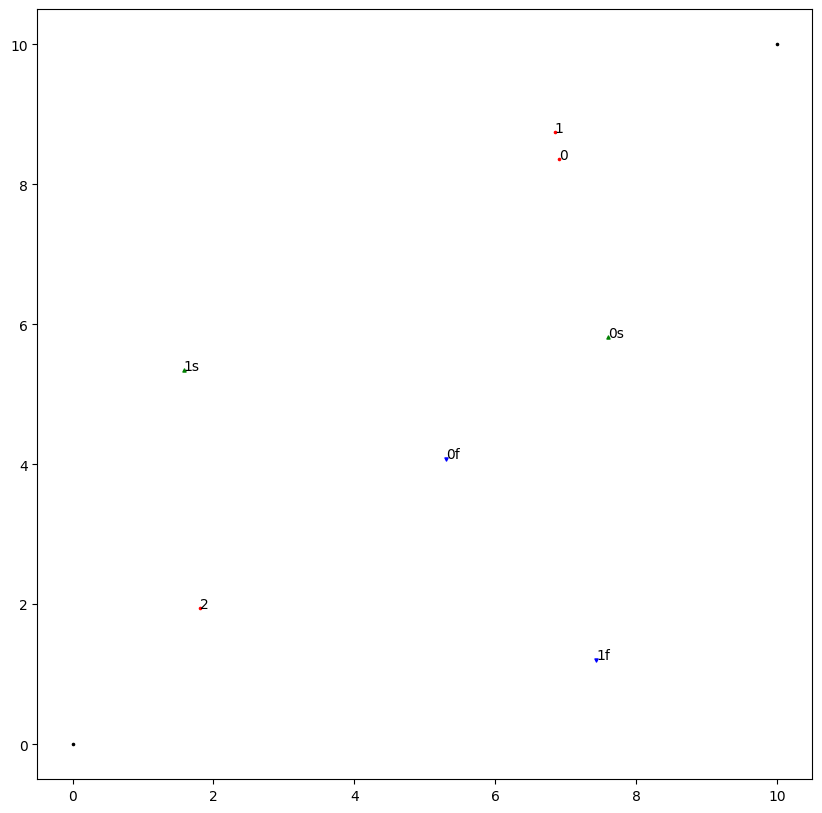

In [14]:
import matplotlib.pyplot as plt
from src.objects.point import Point
from src.objects.gamble_triple import random_triple

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

bounds = (Point(0, 0), Point(10, 10)) # our square city
    
bounds[0].plot(ax, color='black')
bounds[1].plot(ax, color='black')

triple = random_triple(bounds, max_items=3)
print(triple)
triple.plot(ax)

### Dispatch


In fact the dispatch solves the problem of matching on biparties graph: the nodes of the first party are couriers, of the second are orders. We need to fing matching.

The baseline dispatch algorithm is a Hungarian-dispatch. It runs hungarian matching algorithm on weighted graph, where edge is a pair courier-order and the weight is distance between them. We solve the minimization problem.

In [16]:
from src.dispatch.dispatch import Dispatch
dsp = Dispatch() 

dsp(triple)

[(0, 0), (1, 2)]

# Simulator

To simulate the real world we need simulator

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.utils import *

from src.simulator.simulator import Simulator
from src.simulator.graphics import plot_CR, plot_counts

Let's firstly 2 main objects of the project:
* dispatch - the box, that assigns couriers on orders
* simulator - a virtual environment that simulates the real world (the motion of couriers, cancelling of orders, ect)

You can configure the simulator parameters in `environment_config.json` file

In [18]:
sim = Simulator(step=0.5) # the step is the distance which courier makes for each iteration of dispatch

The code below visualizes per-iteration snapshots of all active routes

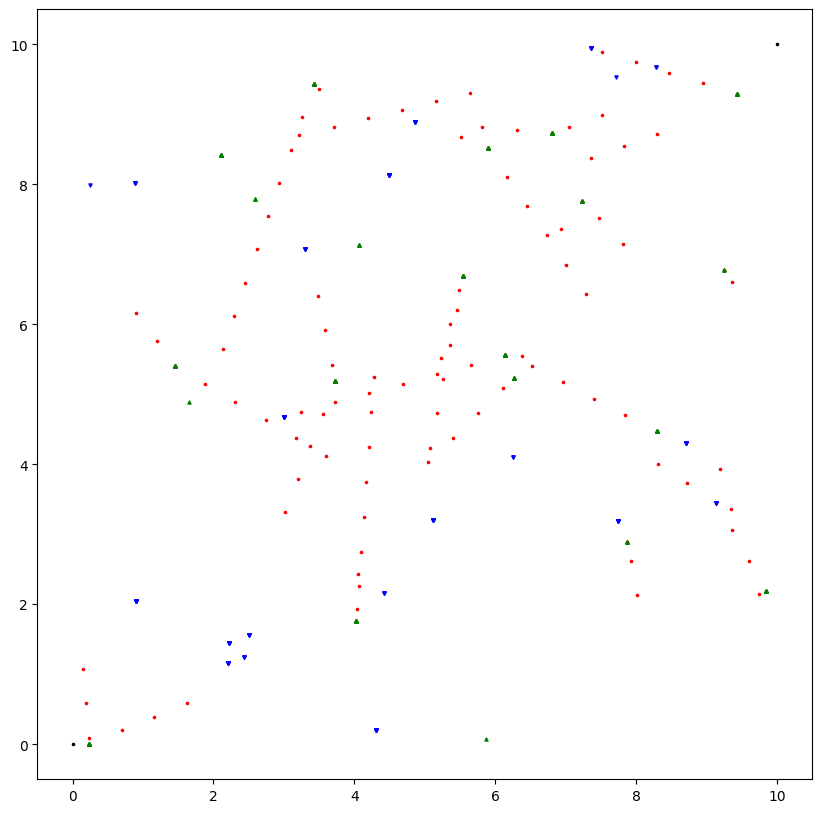

In [19]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
sim.corner_bounds[0].plot(ax, color='black')
sim.corner_bounds[1].plot(ax, color='black')

all_metrics = []
for i in range(10): # run simulator for 10 iterations
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    state = sim.GetState()
    sim.Next(dsp(state))
    for ar in sim.active_routes.items():
        ar.plot(ax)

Also, we can see by-iterations statistics of the whole simulation

In [20]:
pd.DataFrame(all_metrics).set_index('iteration')

,completed_orders,finished_orders,current_free_couriers,current_free_orders,current_active_routes,avg_eta
iteration,,,,,,
0,0,0,20,3,0,0.000000
1,0,0,17,2,3,0.797094
2,0,0,15,2,5,1.229871
3,0,0,13,2,7,1.589839
4,0,0,11,2,9,1.247532
5,1,1,10,2,10,2.203727
6,1,1,8,2,12,0.853412
7,1,1,6,2,14,1.776690
8,1,1,4,2,16,3.142927


Let's run the simulation for longer time and see the convergence of bussiness metrics

In [21]:
all_metrics = []
for i in range(2000): # run simulator for 10 iterations
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    state = sim.GetState()
    sim.Next(dsp(state))

### Our main metric is CR - the rate of success (completed) orders

micro average CR:  0.6977587563727752
macro average CR:  0.6953915030405503


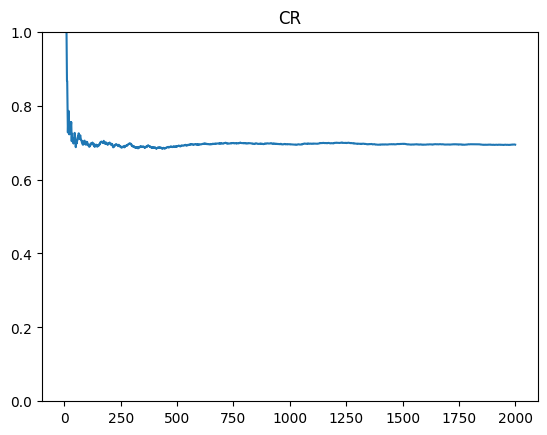

average free couriers:  1.384
average free orders:  13.2015
average active routes:  18.616


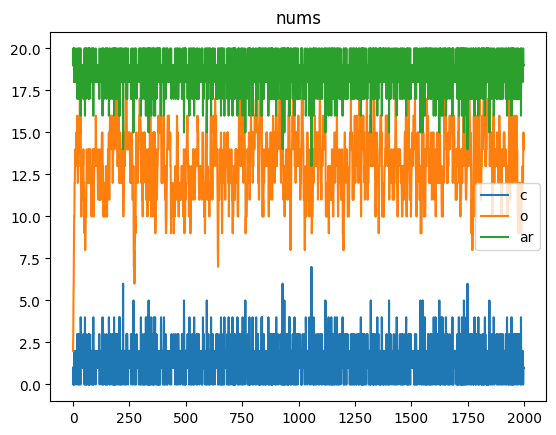

In [6]:
plot_CR(all_metrics)
plot_counts(all_metrics)

Also, we can view some dispatch statistics - more technical metrics

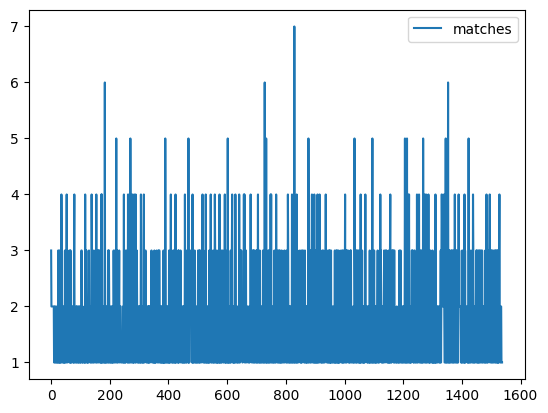

In [7]:
# plt.plot(sim.dispatch.statistics['avg_scores'], label='avg_scores')
plt.plot(dsp.statistics['num_assignments'], label='matches')
plt.legend()
plt.show()

# Neural-network-based dispatch

The idea is to use NNs in dispatch to solve the assignment problem.

Let's firstly decompose the problem

## Positional encoder

Every point is individual. In some areas there can be many orders (because for example there is a storage of big compaby). In some areas there may be bad roads, some the couriers are rare there. That means that we need to encode each point into emdeddings. The PositionalEncoder will do it.

It is trained on the problem of prediction a distance between 2 random points. Embeddings of these points are concated and then followed by linear layer. 

The training code is below

log-losses:  [33.74990146636963, 33.1128967666626, 33.63333358764648, 32.81721992492676, 33.17711879730225]


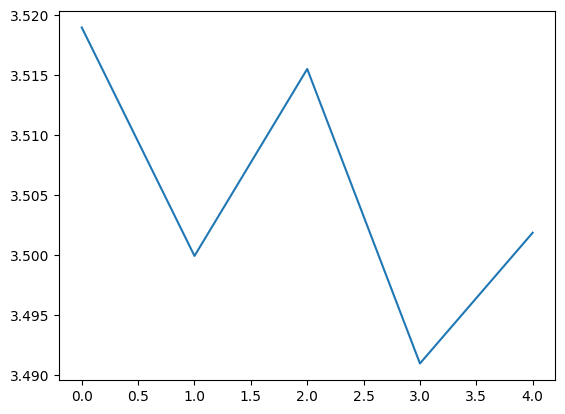

In [8]:
from src.objects.point import Point, get_random_point
from src.networks.points_distance_net import PointDistNet
from src.objects.utils import distance
from IPython.display import clear_output

batch_size = 64
n_epochs = 5
n_iters = 100
bounds = (Point(0, 0), Point(10, 10))
device = None #torch.device('cuda:0')

net = PointDistNet(64, 128, device)
scorer = ETAScoring()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, epochs=n_epochs, steps_per_epoch=n_iters)

losses = []
for epoch in range(n_epochs):
    rolling_loss = []
    for iter in range(n_iters):
        real_distances = []
        pts1 = []
        pts2 = []
        for _ in range(batch_size):
            p1 = get_random_point(bounds)
            p2 = get_random_point(bounds)
            pts1.append(p1)
            pts2.append(p2)
            real_distances.append(distance(p1, p2))

        optimizer.zero_grad()
        mse_loss = nn.MSELoss()
        preds = net(pts1, pts2)
        loss = mse_loss(preds, torch.tensor(real_distances, device=net.device))
        loss.backward()
        optimizer.step()

        rolling_loss.append(loss.item())

    losses.append(np.mean(rolling_loss))
    if epoch % 1 == 0:
        clear_output()
        print('log-losses: ', losses[-50:])
        plt.plot(np.log(losses))
        plt.show()

I trained the model till 0.01-loss convergence. I think that more precision is useless because of overfitting on the exact problem.

In [9]:
import torch
from src.networks.encoders import PointEncoder
from src.objects.point import Point, get_random_point
device = torch.device('cpu')
pe = PointEncoder(64, device=device)
pe.load_state_dict(torch.load('pretrained_models/point_encoder64/point_encoder64.pt', map_location=device))

random_point = get_random_point()
embedding = pe(random_point)
print('embedding shape:', embedding.shape)
print('point embedding:', embedding)

embedding shape: torch.Size([64])
point embedding: tensor([ 0.8044,  0.7751,  0.0371,  0.2381,  0.0362, -0.7646,  0.9217,  0.7621,
         0.9790,  0.8143, -0.9984,  0.9823,  0.1332,  0.4869, -0.9872,  0.6146,
         0.0604,  0.4271,  0.2642,  0.9651, -0.0292,  0.3489,  0.7100,  0.2647,
         0.8407, -0.5879,  0.1702,  0.6380,  0.7146, -0.3842,  0.9593,  0.0423,
        -0.9009, -0.5263, -0.9434, -0.2669, -0.7580, -0.4523,  0.9986,  0.7290,
        -0.8116,  0.4668,  0.9894,  0.8830, -0.9856,  0.2799, -0.3689,  0.7513,
        -0.4129, -0.9636, -0.9621, -0.6617, -0.8215,  0.9898, -0.3849, -0.9131,
         0.2839, -0.9341,  0.9017, -0.1950, -0.8913,  0.3279, -0.1702, -0.5634])


## Network architecture

The input of dispatch at every iteration is a GambleTriple.
It contains 3 lists of items:
* list of unassigned orders
* list of unassigned couriers
* list of active routes

Every item in the list can be embedded. For example, a given order has a source point, a destination point and some time information about the order. All these features can be edmedded, so the order can be represented as a vector. The same logic works for courier and active roure. So, the input of our NN is 3 sequnces of vectors. 

The output of the dispatch should be assignments. They can be achieved by solving the maximal matching in bipartite graph. Edges and couriers are the vertexes of this graph. The score of a given edge shows how the corresponding courier suites the corresponding order.
Edges scores can be represented by a matrix of shape [num_orders, num_couriers+1]. '+1' means a fake courier - a given order is not assigned. This matrix is the outpus of our NN.

As a seq2seq problem I solve the problem using Transformer architecture. Every layer of the whole transformer consists of 2 decoders - for the orders and for the couriers. They attend on each other and on active routes. At the end we have in fact a query-key matrix, which is in fact our output

## Supervised learning: cloning training

I train the NN on supervised task. 
We have a groundtruth baseine: let's say that the groundtruth baseline of edge score is ETA (distance from corier to a source point). We want to minimize it via Hungarian algoriths which solves exactly our problem. Let's use it's assignments as targets. Therefore, we will have bool matrix where True on (i, j) position means that we need to asssign i-th order on j-th courier.

To get our NN's predictions we just call softmax of our output matrix.
The training code you can find at `training_clone.py`

## Comparing of baseline algorithm versus NN-based dispatch

Firstly, let's check the difference in assignmetns

In [23]:
import torch
from src.networks.encoders import PointEncoder
from src.networks.encoders.gamble_encoder import GambleTripleEncoder
from src.networks.scoring_networks.net1 import ScoringNet
from src.dispatch.dispatch import NeuralDispatch

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

with open('configs/training_settings.json') as f:
    training_settings = json.load(f)
with open('configs/network_hyperparams.json') as f:
    hyperparams = json.load(f)
with open('configs/run_ids.json') as f:
    run_id = json.load(f)['cloning']
with open('configs/paths.json') as f:
    paths = json.load(f)

net = ScoringNet(
    n_layers=hyperparams['n_layers'],
    d_model=hyperparams['d_model'],
    n_head=hyperparams['n_head'],
    dim_ff=hyperparams['dim_ff'],
    path_weights=paths['pretrained_net'] if training_settings['use_pretrained'] else None,
    device=device
)

encoder = GambleTripleEncoder(
    number_enc_dim=hyperparams['number_enc_dim'],
    d_model=hyperparams['d_model'],
    point_enc_dim=hyperparams['point_enc_dim'],
    path_weights=paths['pretrained_encoder'] if training_settings['use_pretrained'] else None,
    device=device
)

encoder.eval()
net.eval()

device: cpu
net weights loaded successfuly!
gamble encoder weights loaded successfuly!


In [24]:
neural_dsp = NeuralDispatch(net, encoder)
hungarian_dsp = Dispatch()

In [12]:
from src.simulator.graphics import plot_CR
neural_sim = Simulator()
hungarian_sim = Simulator()

neural_metrics = []
hungarian_metrics = []
for i in range(1000):
    neural_sim.Next(neural_dsp(neural_sim.GetState()))
    neural_metrics.append(neural_sim.GetMetrics())
    hungarian_sim.Next(hungarian_dsp(hungarian_sim.GetState()))
    hungarian_metrics.append(hungarian_sim.GetMetrics())

plot_CR(hungarian_metrics)


  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: 'int' object is not subscriptable

Model accuracy is 80+%
10% is lost on incorrect assignments of real couriers
10% is lost on fake courier assignment

With growth of max_items accuracy of model decrease

Looks like the model understancd that there is no sense of masked couriers assignments

#### Secondly, let's look on business metrics like CR

Default groundtruth dispatch

micro average CR:  0.6653572737557985
macro average CR:  0.6557889693609457


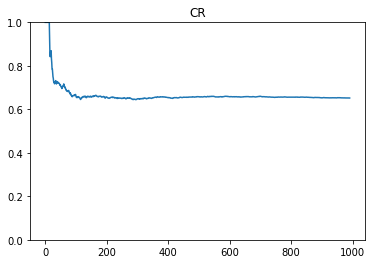

In [1]:
from dispatch.dispatch import Dispatch
from simulator.base_simulator import BaseSimulator
from simulator.graphics import plot_CR

dsp = Dispatch()
sim = BaseSimulator(dsp)

all_metrics = []
for i in range(1000):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()

plot_CR(all_metrics)

NN dispatch

100%|██████████| 1000/1000 [00:55<00:00, 17.93it/s]


micro average CR:  0.49022442522381277
macro average CR:  0.4548339711301314


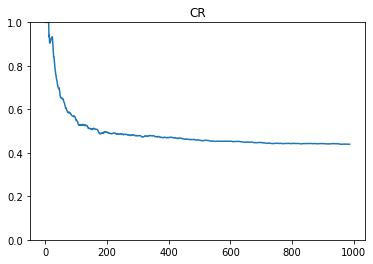

In [3]:
from dispatch.dispatch import NeuralDispatch
from simulator.base_simulator import BaseSimulator
from tqdm import tqdm

dsp = NeuralDispatch(net)
sim = BaseSimulator(dsp)

all_metrics = []
for i in tqdm(range(1000)):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()

plot_CR(all_metrics)

In such base simulations NN dispatch has 15% CR lower